## Vizualisation 
<br/>
it aims to plot some slices of the image registrated, and of the mask to obtain a better understanding
of the registration process
<br/>  
<br/>

Overview :   
- Mask interpolation visualization
- Data resizing



<br/>   
  
### Mask interpolation
<br/>
  One of the problem i have with the calcul of the Dice score is that it implies to interpolate a segmentation of discret values 0-1-2-3-4 with a flow map. However the flow map has been built with a 3D scan of "continuous" value between 0 and 1. I am not sure if it is a real problem because interpolation is just a transformation. 

In [33]:
#loading two scan
from Dataloaders.registration_loader import get_dataloaders
from config import dataloader_config
from torchvision import transforms
from monai.transforms import AddChannel


t = transforms.Compose([transforms.ToTensor(), AddChannel()])
            
training_generator, validation_generator=get_dataloaders(dataloader_config, t)
fixed_image,moving_image,fixed_mask,moving_mask=next(iter(training_generator))

In [34]:
from Model import model
from config import model_config
import os
import torch
# import voxelmorph with pytorch backend
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  

test_net=model(model_config)

#pas de network qui fonctionne pour le moment on loadera plus tard
#loading the trained network
#root_model='/home/luther/Documents/Projet_3A/VectorMorph/models/1000.pt'
#test_net.net.load_state_dict(torch.load(root_model, map_location=test_net.device))

flow_field_nul = torch.zeros([1,3,160,192,224])
flow_field_random=torch.abs(torch.randn([1,3,160,192,224])) 
pred_mask_nul = test_net.net.transformer(moving_mask.float(), flow_field_nul)
pred_mask_random=test_net.net.transformer(moving_mask.float(), flow_field_random)

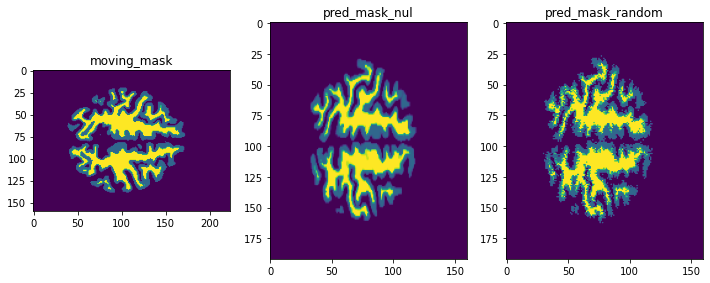

In [30]:
import matplotlib.pyplot as plt

moving_mask = moving_mask[0][0].permute(1, 0, 2)
pred_mask_nul = pred_mask_nul[0][0].permute(1, 0, 2)
pred_mask_random = torch.round(pred_mask_random[0][0].permute(1, 0, 2))

# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 3, 1)
plt.title("moving_mask")
plt.imshow(moving_mask[:, :, 50])
plt.subplot(1, 3, 2)
plt.title("pred_mask_nul")
plt.imshow(pred_mask_nul[:, :, 50])
plt.subplot(1, 3, 3)
plt.title("pred_mask_random")
plt.imshow(pred_mask_random[:, :, 50])

plt.show()



With a random flow field and a round we obtain the same unique labels. It seems to work, interpolation just change the voxel position not its values.
<br/>
<br/>
### Data resizing
<br/>
the scanners are to big to be processed by our computers, so we decided to resize them to shape 96,96,128.
The tricky part is with the mask, a "dumb" downscaling won't work. We just downpool with a most criteria for labels selections instead of avg criteria.

In [2]:
from Dataloaders.MRI_loader import load, get_labels_list, get_data_dicts
from config import dataloader_config


partition=get_data_dicts(dataloader_config['rootdir'],dataloader_config['valid_ratio'])
fixed_image,moving_image,fixed_mask,moving_mask=load(partition['train'][0],partition['train'][1],vectorize=False)
fixed_image.shape

(160, 192, 224)

(96, 96, 128)


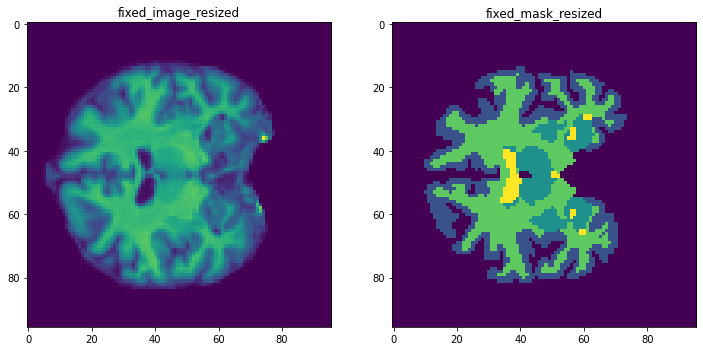

In [5]:
from process.resize import addPadding, pooling3d
import matplotlib.pyplot as plt

fixed_image_resized = addPadding(pooling3d(fixed_image, (2,2,2), (2,2,2), technique='avg'),(8,0,8))
fixed_mask_resized = addPadding(pooling3d(fixed_mask, (2,2,2), (2,2,2), technique='most'),(8,0,8))
print(fixed_image_resized.shape)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(fixed_image_resized[:,:,64])
plt.title("fixed_image_resized")
plt.subplot(1, 2, 2)
plt.imshow(fixed_mask_resized[:,:,64])
plt.title("fixed_mask_resized")


plt.show()


### Loss investigation
<br/> We have a difference between the loss values with and whitout vectorization. Let's investigate.

In [1]:
from Dataloaders.registration_loader import get_dataloaders
from config import dataloader_config

from process.losses import MSE
import torch
from tqdm import tqdm

dataloader_config['vectorize']=False
train_loader, test_loader=get_dataloaders(dataloader_config)

temp=0
for fixed_image,moving_image,fixed_mask,moving_mask in train_loader:
    l=MSE(fixed_image, moving_image)
    temp+=l
    print(l, torch.mean(fixed_image), torch.std(fixed_image))

print(temp)


tensor(0.0027, dtype=torch.float64) tensor(0.0541, dtype=torch.float64) tensor(0.1139, dtype=torch.float64)
tensor(0.0021, dtype=torch.float64) tensor(0.0533, dtype=torch.float64) tensor(0.1138, dtype=torch.float64)
tensor(0.0018, dtype=torch.float64) tensor(0.0523, dtype=torch.float64) tensor(0.1112, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(0.0490, dtype=torch.float64) tensor(0.1092, dtype=torch.float64)
tensor(0.0026, dtype=torch.float64) tensor(0.0503, dtype=torch.float64) tensor(0.1110, dtype=torch.float64)
tensor(0.0025, dtype=torch.float64) tensor(0.0506, dtype=torch.float64) tensor(0.1097, dtype=torch.float64)
tensor(0.0033, dtype=torch.float64) tensor(0.0450, dtype=torch.float64) tensor(0.1044, dtype=torch.float64)
tensor(0.0021, dtype=torch.float64) tensor(0.0528, dtype=torch.float64) tensor(0.1131, dtype=torch.float64)
tensor(0.0021, dtype=torch.float64) tensor(0.0508, dtype=torch.float64) tensor(0.1102, dtype=torch.float64)
tensor(0.0027, dtype=torch.float

In [2]:
dataloader_config['vectorize']=True

train_loader, test_loader=get_dataloaders(dataloader_config)

temp=0
for fixed_image,moving_image,fixed_mask,moving_mask in train_loader:
    l=MSE(fixed_image, moving_image)
    
    temp+=l
    print(l, torch.mean(fixed_image), torch.std(fixed_image))
print(temp)


tensor(0.0041, dtype=torch.float64) tensor(-1.1950e-05, dtype=torch.float64) tensor(0.1002, dtype=torch.float64)
tensor(0.0028, dtype=torch.float64) tensor(-4.1968e-06, dtype=torch.float64) tensor(0.1050, dtype=torch.float64)
tensor(0.0045, dtype=torch.float64) tensor(-3.5494e-05, dtype=torch.float64) tensor(0.0784, dtype=torch.float64)
tensor(0.0023, dtype=torch.float64) tensor(-6.7447e-05, dtype=torch.float64) tensor(0.0993, dtype=torch.float64)
tensor(0.0035, dtype=torch.float64) tensor(-1.3800e-05, dtype=torch.float64) tensor(0.0957, dtype=torch.float64)
tensor(0.0034, dtype=torch.float64) tensor(-2.6189e-05, dtype=torch.float64) tensor(0.1148, dtype=torch.float64)
tensor(0.0020, dtype=torch.float64) tensor(-1.1972e-05, dtype=torch.float64) tensor(0.0914, dtype=torch.float64)
tensor(0.0022, dtype=torch.float64) tensor(-5.2041e-05, dtype=torch.float64) tensor(0.0906, dtype=torch.float64)
tensor(0.0028, dtype=torch.float64) tensor(-2.5656e-05, dtype=torch.float64) tensor(0.0869, dtyp

The difference came from the non-normalization of the vectorized data

### Loss recovery
<br/>
Les loss sont dans un fichiers texte, petit script pour les récupérer 

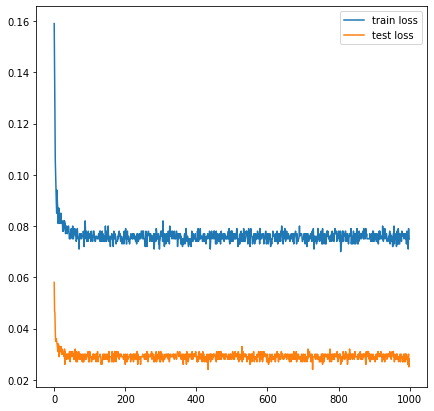

In [24]:
import matplotlib.pyplot as plt

def loss_recovery(path):
    train_loss=[]
    test_loss=[]
    with open(path, 'r') as f:
        data=f.readlines()
        for line in data:
            if 'Train Loss' in line:
                train_loss.append(float(line[-6:]))
            elif 'Test Loss' in line:
                test_loss.append(float(line[-6:]))
    plt.figure(figsize=(7,7))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train loss','test loss'])
    plt.show()

loss_recovery('./training/training_stan.out')

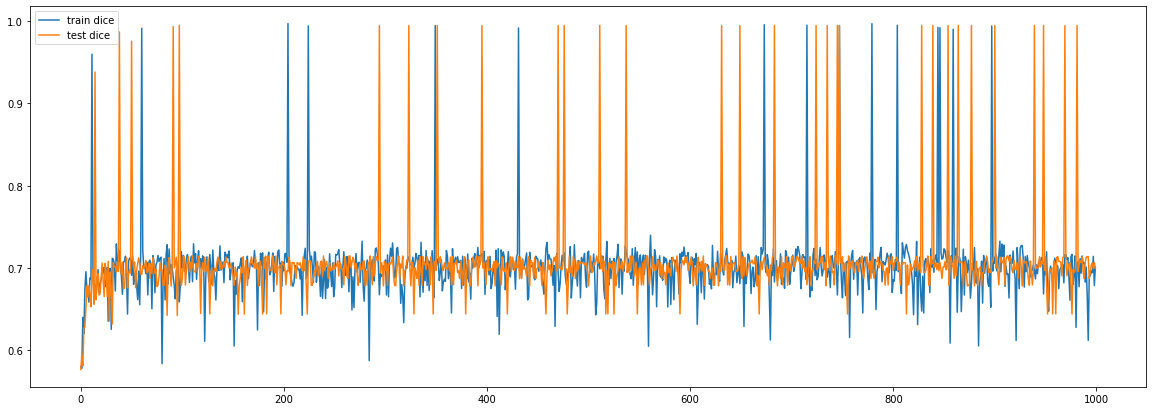

In [54]:

import matplotlib.pyplot as plt

def Dice_recovery(path):
    train_dice=[]
    test_dice=[]
    with open(path, 'r') as f:
        data=f.readlines()
        for line in data:
            if 'Train Mean Dice' in line:
                train_dice.append(float(line[29:]))
            elif 'Test Mean Dice' in line:
                if 'Best Test Mean Dice' not in line:
                    test_dice.append(float(line[29:]))
    plt.figure(figsize=(20,7))
    
    plt.plot(train_dice)
    plt.plot(test_dice)

   # plt.scatter([i for i in range(len(train_dice))],train_dice)
   # plt.scatter([i for i in range(len(test_dice))],test_dice)
    plt.legend(['train dice','test dice'])
    plt.show()

test=Dice_recovery('./training/training_stan.out')

#### Model evaluation

In [1]:
from main import evaluate
from config import model_config, dataloader_config, train_config, criterion_config, scheduler_config
model_state_dict_path=""
trainer = evaluate(model_state_dict_path, model_config, criterion_config, scheduler_config)

In [ ]:
#loading two scan for visualization
from Dataloaders.registration_loader import get_dataloaders
import torch

fixed_image,moving_image,fixed_mask,moving_mask=next(iter(trainer.testloader))
fixed_image, moving_image = fixed_image.to(trainer.model.device), moving_image.to(trainer.model.device)
moving_mask = moving_mask.to(trainer.model.device)

with torch.no_grad():
            #fixed_image_mask, moving_image_mask = fixed_image_mask.to(self.model.device), moving_image_mask.to(self.model.device)
            pred_image, flow_field = trainer.model.net(moving_image.float(),fixed_image.float())
            pred_mask = trainer.model.net.transformer(moving_mask.float(), flow_field)
            loss, train_mean_dice = trainer.model.criterion(pred_image, pred_mask.detach().cpu(), fixed_image, fixed_mask, flow_field)
            
fixed_image,moving_image,fixed_mask,moving_mask=fixed_image.detach().cpu().numpy(),moving_image.detach().cpu().numpy(),fixed_mask.detach().cpu().numpy(),moving_mask.detach().cpu().numpy()
pred_image, flow_field, pred_mask = pred_image.detach().cpu().numpy(), flow_field.detach().cpu().numpy(), pred_mask.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(fixed_image[:,:,64])
plt.title("fixed_image")
plt.subplot(1, 4, 2)
plt.imshow(fixed_mask[:,:,64])
plt.title("fixed_mask")
plt.subplot(1, 4, 3)
plt.imshow(pred_image[:,:,64])
plt.title("pred_image")
plt.subplot(1, 4, 4)
plt.imshow(pred_mask[:,:,64])
plt.title("pred_mask")

plt.show()